In [1]:
import matplotlib.pyplot as plt
import numpy as np
from abc import abstractmethod    
from itertools import cycle
from IPython.display import clear_output
import time

In [2]:
### world frame
class Frame(object):
    """Class for defining the frame in which obstacles and robots live."""
    
    degree = 2
    bounds = np.array([[10], 
                       [10]])
    time = 0
    dbots = []
    obstacles = []
    
    def __init__(self, dbots=[], obstacles=[], **kwargs):
        self.__dict__.update(kwargs)
        self.dbots = dbots
        self.obstacles = obstacles
        
    def add_dbot(self, dbot):
        assert type(dbot) == Dbot, "dbot must be a Dbot dawg."
        self.robots.append(dbot)
    
    def add_obstacle(self, obstacle):
        assert type(obstacle) == RectangleObstacle, "obstacle must be an Obstacle dawg."
        self.obstacles.append(obstacle)
        
    def show_frame(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
        
        for obstacle in self.obstacles:
            obstacle.plot(plt)
            rectangle = plt.Rectangle((0,0), 50, 20, fc='blue',ec="red") 
        ax.set_xlim(0, self.bounds[0])
        ax.set_ylim(0, self.bounds[1])
        plt.show()

In [3]:
class Obstacle(object):
    """Class used to defines the structure of obstacles"""
    def __init__(self):
        super.__init__()
    
    @abstractmethod
    def is_point_inside(self, point):
        pass
    
    @abstractmethod
    def is_trajectory_intersected(self, *argv):
        pass
    
    @abstractmethod
    def plot(self, plt):
        pass

class RectangleObstacle(Obstacle):
    """Class that creates rectangle shaped objects"""
    def __init__(self, bottom_corner, top_corner):        
        self.min_x = bottom_corner[0]
        self.min_y = bottom_corner[1]
        self.max_x = top_corner[0]
        self.max_y = top_corner[1]
        
    def is_point_inside(self, point):
        pt_x, pt_y = point[0], point[1]
        return self.max_x >= pt_x and self.min_x <= pt_x and self.max_y >= pt_y and self.min_y <= pt_y
    
    def is_trajectory_intersected(self, *argv):
        """Method uses disrete collision detection. Will expand to continous detection if needed -- however, we will probably just increase sample rate as needed instead."""
        return any([self.is_point_inside(point) for point in argv])
    
    def plot(self, plt):
        rectangle = plt.Rectangle((self.min_x,self.min_y), self.max_x - self.min_x,self.max_y-self.min_y, fc='black',ec="red")
        plt.gca().add_patch(rectangle)
    



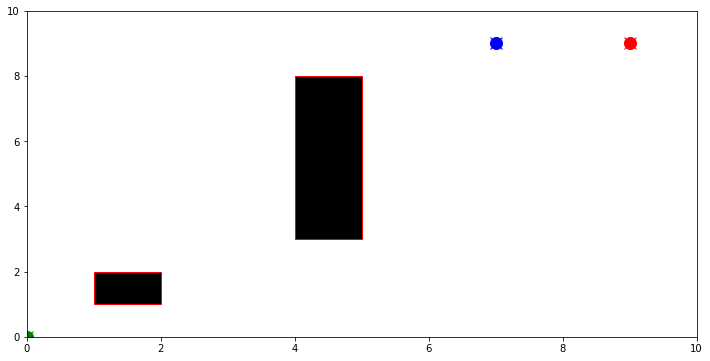

In [4]:
class dbot(object):
    """Class for defining dot represented robots"""
    def __init__(self, goal):
        self.goal = goal
        
    def get_goal(self):
        return self.goal
    
    @abstractmethod
    def get_position(self, t):
        pass

class HomonomicRobot(dbot):
    """Obstacle less holonomic robot path planner"""
    def __init__(self, init, goal, max_time):
        super().__init__(goal)
        self.init = init
        self.max_time = max_time
    
    def get_position(self, t):
        if t > self.max_time:
            return self.goal
        return (t / self.max_time) * (self.goal - self.init) + self.init
    
class BFSInstantHolonomicRobot(dbot):
    """Obstacle Avoidant BFS holonomic Robot"""
    obs = []
    step_size = 1
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        return [current_state + [[self.step_size], [0]], 
                current_state + [[-self.step_size], [0]],
                current_state + [[0], [self.step_size]],
                current_state + [[0], [-self.step_size]]]
    
    def __find_path(self):
        self.visited = [] # List to keep track of visited nodes.
        queue = []     #Initialize a queue
        self.visited.append(tuple(self.init.ravel()))
        queue.append((self.init, [tuple(self.init.ravel())]))

        while queue:
            s, path = queue.pop(0)
            if s[0] == self.goal[0] and s[1] == self.goal[1]:
                self.path = path
                return path
            for neighbour in self.__get_moves(s):
                neighbourt = tuple(neighbour.ravel())
                if neighbourt not in self.visited and not any([bool(ob.is_point_inside(neighbour)) for ob in self.obs]):
                    self.visited.append(neighbourt)
                    queue.append((neighbour, path + [neighbourt]))
            
    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1]
        return self.path[np.round(t)]
    
rect = RectangleObstacle(np.array([[4], [3]]), np.array([[5], [8]]))
rect2 = RectangleObstacle(np.array([[1], [1]]), np.array([[2], [2]]))
InstantBFSBot = BFSInstantHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [9.]]), step_size = 0.5, obs = [rect, rect2])
InstantBFSBot2 = BFSInstantHolonomicRobot(np.array([[7.], [9.]]), np.array([[0.], [0.]]), step_size = 0.5, obs = [rect, rect2])
InstantBFSBot3 = BFSInstantHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [9.]]), step_size = 0.5, obs = [rect, rect2])

for t in range(50):
    clear_output(wait=True)
    Frame(dbots=[InstantBFSBot, InstantBFSBot2, InstantBFSBot3], obstacles=[rect, rect2], time = t).show_frame()

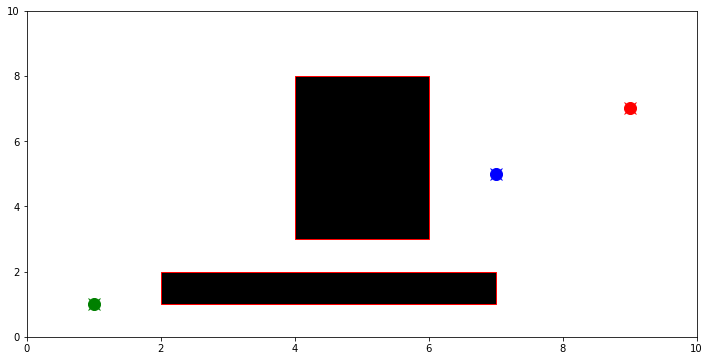

In [26]:
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self) -> bool:
        return not self.elements
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

class AStarInstantHolonomicRobot(dbot):
    """Obstacle Avoidant AStar holonomic Robot"""
    obs = []
    step_size = 1
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        moves = [[self.step_size, 0], [-self.step_size, 0], [0, self.step_size], [0, -self.step_size]]
        return [tuple(np.add(current_state, m)) for m in moves]
    
    def __heuristic(self, a, b) -> float:
        (x1, y1) = a
        (x2, y2) = b
        return abs(x1 - x2) + abs(y1 - y2)

    def __find_path(self):
        start = tuple(self.init.ravel())
        goal = tuple(self.goal.ravel())
        frontier = PriorityQueue()
        frontier.put((start, [start]), 0)
        came_from = {}
        cost_so_far = {}
        came_from[start] = None
        cost_so_far[start] = 0

        while not frontier.empty():
            current, path = frontier.get()

            if current == goal:
                self.path = path
                return path
            
            for neighbour in self.__get_moves(current):
                new_cost = cost_so_far[current] + self.step_size
                
                if neighbour not in cost_so_far or new_cost < cost_so_far[neighbour]:
                    if not any([bool(ob.is_point_inside(neighbour)) for ob in self.obs]):
                        cost_so_far[neighbour] = new_cost
                        priority = new_cost + self.__heuristic(neighbour, goal)
                        frontier.put((neighbour, path + [neighbour]), priority)
                        came_from[neighbour] = current

    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1]
        return self.path[np.round(t)]
    
rect = RectangleObstacle(np.array([[4], [3]]), np.array([[6], [8]]))
rect2 = RectangleObstacle(np.array([[7], [1]]), np.array([[2], [2]]))
InstantAStarBot = AStarInstantHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [5.]]), step_size = 0.5, obs = [rect, rect2])
InstantAStarBot2 = AStarInstantHolonomicRobot(np.array([[7.], [9.]]), np.array([[1.], [1.]]), step_size = 0.5, obs = [rect, rect2])
InstantAStarBot3 = AStarInstantHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [7.]]), step_size = 0.5, obs = [rect, rect2])

for t in range(50):
    clear_output(wait=True)
    Frame(dbots=[InstantAStarBot, InstantAStarBot2, InstantAStarBot3], obstacles=[rect, rect2], time = t).show_frame()

In [31]:
class AStarDynamicHolonomicRobot(dbot):
    """Obstacle Avoidant AStar holonomic Robot"""
    obs = []
    step_size = 1
    time = 0.5
    accel = (1, 1)
    max_vel = 2
    
    def __init__(self, init, goal, **kwargs):
        super().__init__(goal)
        self.__dict__.update(kwargs)
        self.init = init  
        self.path = self.__find_path()
    
    def __get_moves(self, current_state):
        current_pos = current_state[0]
        current_vel = current_state[1]
        accels = [(self.accel[0], self.accel[1]), 
             (self.accel[0], -self.accel[1]), 
             (-self.accel[0], self.accel[1]), 
             (-self.accel[0], -self.accel[1]),
             (self.accel[0], 0), 
             (-self.accel[0], 0), 
             (0, self.accel[1]), 
             (0, -self.accel[1])]
        
        v = [tuple(np.add(current_vel, np.multiply(a, self.time))) for a in accels]
        x = [tuple(np.add(current_pos, np.add(np.multiply(current_vel, self.time), np.multiply(0.5*self.time**2, a)))) for a in accels]
        return list(zip(x, v))
    
    def __heuristic(self, a, b) -> float:
        (x1, y1) = a[0]
        (x2, y2) = b[0]
        return abs(x1 - x2) + abs(y1 - y2) / self.max_vel

    def __find_path(self):
        start = tuple(self.init.ravel())
        goal = tuple(self.goal.ravel())
        frontier = PriorityQueue()
        frontier.put(((start, (0, 0)), [(start, (0, 0))]), 0)
        came_from = {}
        cost_so_far = {}
        came_from[(start, (0, 0))] = None
        cost_so_far[(start, (0, 0))] = 0

        while not frontier.empty():
            current, path = frontier.get()
            
            if current == (goal, (0, 0)):
                self.path = path
                return path
            
            for neighbour in self.__get_moves(current):
                new_cost = cost_so_far[current] + 1
                
                if neighbour not in cost_so_far or new_cost < cost_so_far[neighbour]:
                    if not any([bool(ob.is_point_inside(neighbour[0])) for ob in self.obs]):
                        cost_so_far[neighbour] = new_cost
                        priority = new_cost + self.__heuristic(neighbour, (goal, (0, 0)))
                        frontier.put((neighbour, path + [neighbour]), priority)
                        came_from[neighbour] = current

    def get_position(self, t):
        if t >= len(self.path):
            return self.path[-1][0]
        return self.path[np.round(t)][0]

rect = RectangleObstacle(np.array([[5], [0]]), np.array([[6], [8]]))
rect2 = RectangleObstacle(np.array([[2], [1]]), np.array([[3], [15]]))
DynamicAStarBot = AStarDynamicHolonomicRobot(np.array([[3.], [4.]]), np.array([[7.], [5.]]), accel = (1, 1), obs = [rect, rect2])
DynamicAStarBot2 = AStarDynamicHolonomicRobot(np.array([[7.], [9.]]), np.array([[1.], [1.]]), accel = (1, 1), obs = [rect, rect2])
DynamicAStarBot3 = AStarDynamicHolonomicRobot(np.array([[3.], [1.]]), np.array([[9.], [7.]]), accel = (1, 1), obs = [rect, rect2])

for t in range(15):
    clear_output(wait=True)
    time.sleep(0.25)
    Frame(dbots=[DynamicAStarBot, DynamicAStarBot2, DynamicAStarBot3], obstacles=[rect, rect2], time = t).show_frame()

KeyboardInterrupt: 

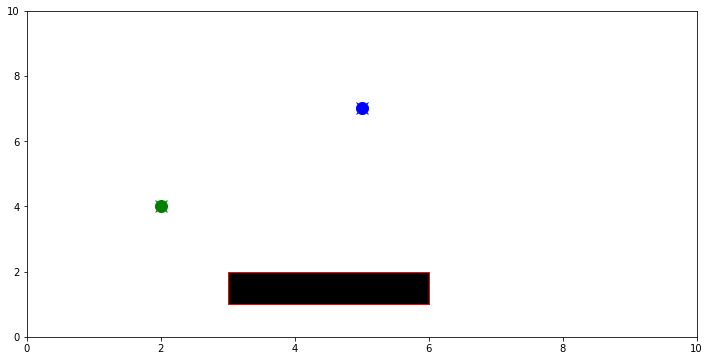

In [32]:
hol_bot = HomonomicRobot(np.array([[3.], [4.]]), np.array([[5.], [7.]]), 19)
for t in range(10):
    print(hol_bot.get_position(t))
hol_bot2 = HomonomicRobot(np.array([[8.], [9.]]), np.array([[2.], [4.]]), 13)
obs = RectangleObstacle(np.array([[3], [1]]), np.array([[6], [2]]))
f2 = Frame(dbots=[hol_bot, hol_bot2])
f2.add_obstacle(obs)
f2.show_frame()
for t in range(20):
    clear_output(wait=True)
    Frame(dbots=[hol_bot, hol_bot2], time = t).show_frame()

In [30]:
obs2 = RectangleObstacle(np.array([[4], [3]]), np.array([[5], [8]]))
l = [hol_bot2.get_position(t) for t in range(10)]
print(obs2.is_trajectory_intersected(*l), obs.is_trajectory_intersected(*l))

True False


Bot 2's velocity: (0.0, 0.0)


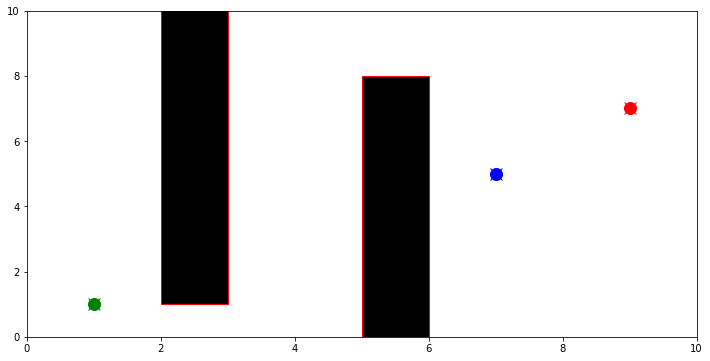

In [35]:
for t in range(18):
    clear_output(wait=True)
    time.sleep(0.25)
    print(f"Bot 2's velocity: {DynamicAStarBot2.path[t][1]}")
    Frame(dbots=[DynamicAStarBot, DynamicAStarBot2, DynamicAStarBot3], obstacles=[rect, rect2], time = t).show_frame()